In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import DataLoader
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from model.featurisation import smiles2graph
from model.CL_model_vas_info import GNNModelWithNewLoss
import pandas as pd


In [2]:
df = pd.read_csv("./data/vsa.csv")  
smiles_list = df["SMILES"].tolist()
smr_vsa_list = [list(map(float, row.split())) for row in df["SMR_VSA"]]

In [5]:
def read_vsa_data(vsa_file):
    df = pd.read_csv(vsa_file)

    def parse_vsa(s):
        try:
            return list(map(float, s.strip('[]').split()))
        except:
            return []

    smr_arrays = df["SMR_VSA"].apply(parse_vsa).tolist()          
    slogp_arrays = df["SlogP_VSA"].apply(parse_vsa).tolist()     
    peoe_arrays = df["PEOE_VSA"].apply(parse_vsa).tolist()       

    properties = list(zip(smr_arrays, slogp_arrays, peoe_arrays))
    
    return df["SMILES"].tolist(), properties

x_smiles, properties = read_vsa_data("./data/vsa.csv")

In [6]:
data_list = smiles2graph(
    x_smiles, y=None, cluster=None, properties=properties, test=False
)
data_list[0]

Data(x=[21, 79], edge_index=[2, 44], edge_attr=[44, 10], global_features=[5], smiles='Cc1cccc(C2=CCN(C(=O)NCCCC#N)CC2)c1', property_0=[1, 10], property_1=[1, 10], property_2=[1, 14])

In [7]:
import torch
from torch_geometric.data import DataLoader
devices = ["cuda" if torch.cuda.is_available() else "cpu"]
model1 = GNNModelWithNewLoss(
        num_node_features=data_list[0].x.shape[1],
        num_edge_features=data_list[0].edge_attr.shape[1],
        num_global_features=data_list[0].global_features.shape[0],
        hidden_dim=512,
        dropout_rate=0.1,
        property_index=1 ,
        save_path= 'premodels/0' 
    ).to(devices[0])

In [8]:
device = devices[0]
ckpt = torch.load(f'premodels/{0}/best_model.pth', map_location=device)
model1.load_state_dict(ckpt['encoder_state_dict'])
model1.eval()

C:\Users\chenxinyi\AppData\Local\Temp\ipykernel_18784\2666661902.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(f'premodels/{0}/best_model.pth', map_l

GNNModelWithNewLoss(
  (conv1): GATConv(79, 512, heads=1)
  (conv2): GATConv(512, 512, heads=1)
  (conv3): GATConv(512, 512, heads=1)
  (bn1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (bn2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (bn3): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (projection_head): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=256, out_features=64, bias=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
)

In [22]:
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict
import torch


def get_murcko_scaffold(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    scaffold = MurckoScaffold.GetScaffoldForMol(mol)
    return Chem.MolToSmiles(scaffold)


def extract_scaffold_groups(smiles_list, embeddings, min_size=10):
    scaffold_to_indices = defaultdict(list)
    for i, smi in enumerate(smiles_list):
        scaffold = get_murcko_scaffold(smi)
        if scaffold:
            scaffold_to_indices[scaffold].append(i)

    # 仅保留样本数大于等于 min_size 的 scaffold 类别
    valid_scaffolds = {k: v for k, v in scaffold_to_indices.items() if len(v) >= min_size}

    # 计算每类内部距离并排序
    scaffold_compactness = []
    for scaffold, indices in valid_scaffolds.items():
        sub_emb = embeddings[indices]
        dists = pairwise_distances(sub_emb)
        compactness = dists.mean()
        scaffold_compactness.append((scaffold, indices, compactness))

    # 按平均距离从小到大排序，选最紧密的前几类
    scaffold_compactness.sort(key=lambda x: x[2])
    return scaffold_compactness[:4]  # 选前4类


def visualize_selected_scaffolds_tsne(embeddings, smiles_list, max_per_class=30):
    selected_scaffolds = extract_scaffold_groups(smiles_list, embeddings)

    selected_embeddings = []
    selected_labels = []

    for i, (scaffold, indices, _) in enumerate(selected_scaffolds):
        if len(indices) > max_per_class:
            sub_emb = embeddings[indices]
            dists = pairwise_distances(sub_emb)
            sum_dists = dists.sum(axis=1)
            top_indices = np.argsort(sum_dists)[:max_per_class]
            chosen_indices = [indices[j] for j in top_indices]
        else:
            chosen_indices = indices

        selected_embeddings.extend(embeddings[chosen_indices])
        selected_labels.extend([f"Class {i+1}"] * len(chosen_indices))

    selected_embeddings = np.array(selected_embeddings)

    # t-SNE降维
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    emb_2d = tsne.fit_transform(selected_embeddings)

    # 绘图
    plt.figure(figsize=(8, 6))
    palette = sns.color_palette("hls", 4)
    label_to_color = {f"Class {i+1}": palette[i] for i in range(4)}
    colors = [label_to_color[label] for label in selected_labels]

    for i in range(4):
        label = f"Class {i+1}"
        idx = [j for j, l in enumerate(selected_labels) if l == label]
        plt.scatter(emb_2d[idx, 0], emb_2d[idx, 1], label=label,
                    s=30, alpha=0.8, edgecolors='k')

    plt.title("t-SNE Visualization of Selected Scaffold Clusters")
    plt.xlabel("t-SNE dim 1")
    plt.ylabel("t-SNE dim 2")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# 用法（确保你有模型和dataloader）：
# embeddings, smiles_list = extract_embeddings_and_smiles(model, dataloader)
# visualize_selected_scaffolds_tsne(embeddings, smiles_list)


In [ ]:
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict
import torch
from sklearn.cluster import KMeans

def extract_embeddings_and_vsa(model, dataloader):
    """
    提取所有分子的 embedding 和 VSA 特征（通过 model.get_property）
    返回：embedding (N, D), vsa_features (N, F)
    """
    model.eval()
    all_embeddings = []
    all_props = []

    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(model.device)
            emb = model._project(model.forward(batch)).detach().cpu()
            prop = model.get_property(batch).detach().cpu()

            all_embeddings.append(emb)
            all_props.append(prop)

    embeddings = torch.cat(all_embeddings, dim=0).numpy()
    vsa_features = torch.cat(all_props, dim=0).numpy()
    return embeddings, vsa_features


def extract_vsa_clusters(vsa_features, n_clusters=4, max_per_class=30):
    # 使用KMeans对VSA特征进行聚类
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(vsa_features)

    selected_embeddings = []
    selected_labels = []

    for i in range(n_clusters):
        indices = np.where(cluster_labels == i)[0]
        if len(indices) > max_per_class:
            sub_vsa = vsa_features[indices]
            dists = pairwise_distances(sub_vsa)
            sum_dists = dists.sum(axis=1)
            top_indices = np.argsort(sum_dists)[:max_per_class]
            chosen_indices = [indices[j] for j in top_indices]
        else:
            chosen_indices = indices

        selected_embeddings.append(chosen_indices)
        selected_labels.extend([f"Cluster {i+1}"] * len(chosen_indices))

    selected_indices_flat = [i for group in selected_embeddings for i in group]
    return selected_indices_flat, selected_labels


def visualize_vsa_clusters_tsne(embeddings, vsa_features, n_clusters=4, max_per_class=30):
    selected_indices, selected_labels = extract_vsa_clusters(vsa_features, n_clusters, max_per_class)
    selected_embeddings = embeddings[selected_indices]

    # t-SNE降维
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    emb_2d = tsne.fit_transform(selected_embeddings)

    # 绘图
    plt.figure(figsize=(8, 6))
    palette = sns.color_palette("hls", n_clusters)
    label_to_color = {f"Cluster {i+1}": palette[i] for i in range(n_clusters)}
    colors = [label_to_color[label] for label in selected_labels]

    for i in range(n_clusters):
        label = f"Cluster {i+1}"
        idx = [j for j, l in enumerate(selected_labels) if l == label]
        plt.scatter(emb_2d[idx, 0], emb_2d[idx, 1], label=label,
                    s=30, alpha=0.8, edgecolors='k')

    plt.title("t-SNE Visualization of Embeddings Colored by VSA Cluster")
    plt.xlabel("t-SNE dim 1")
    plt.ylabel("t-SNE dim 2")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# 用法（确保你有 model 和 dataloader）：
# embeddings, vsa_features = extract_embeddings_and_vsa(model, dataloader)
# visualize_vsa_clusters_tsne(embeddings, vsa_features)


c:\Users\chenxinyi\.conda\envs\torch\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


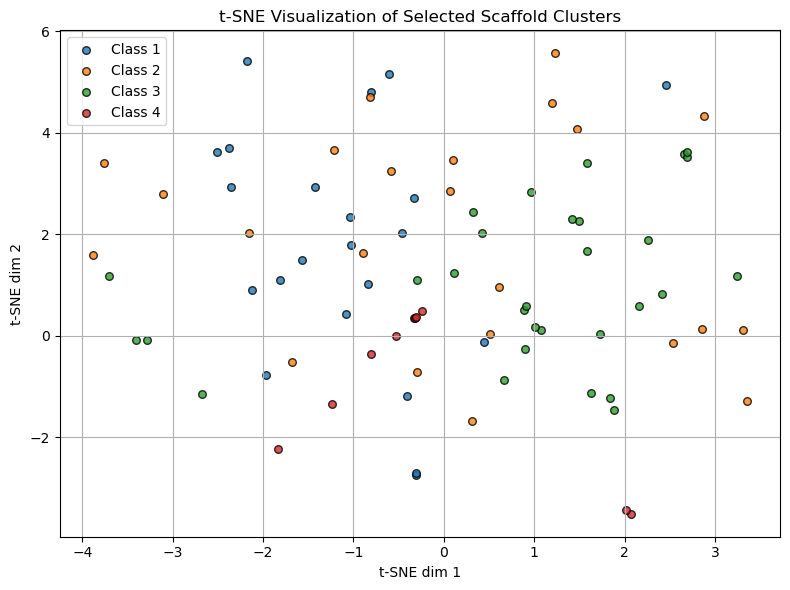

In [23]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataloader = DataLoader(data_list, batch_size=32, shuffle=False)

def extract_embeddings_and_smiles(model, dataloader):
    model.eval()
    all_embeddings = []
    all_smiles = []

    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(model.device)
            emb = model._project(model.forward(batch)).detach().cpu()
            all_embeddings.append(emb)
            all_smiles.extend(batch.smiles)

    all_embeddings = torch.cat(all_embeddings, dim=0).numpy()  # shape: (N, D)
    return all_embeddings, all_smiles

embeddings, smiles_list = extract_embeddings_and_smiles(model1, dataloader)

visualize_selected_scaffolds_tsne(embeddings, smiles_list)


In [7]:
import torch
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

def compute_distances(model, dataloader, anchor_smiles="O", vsa_property='property_0', weight_vsa=0.5, weight_embedding=0.5):
    """
    计算每个分子与锚点（水分子）之间的表示距离
    vsa_property: 选择的VSA分量，可以是 'property_0', 'property_1', 或 'property_2'
    """
    anchor_embedding = None
    anchor_vsa = None
    for data in dataloader:
        data = data.to(model.device)
        prop = model.get_property(data)
        embedding = model._project(model.forward(data))

        if "O" in data.smiles:  # 如果找到水分子
            anchor_embedding = embedding
            anchor_vsa = prop[vsa_property]
            break
    else:
        # 如果没有找到水分子（'O'），则选择第一个分子，并打印它的SMILES
        data = dataloader.dataset[0]
        anchor_smiles = data.smiles
        print(f"Water molecule (O) not found. Using the first molecule: {anchor_smiles}")
        anchor_embedding = model._project(model.forward(data.to(model.device)))
        anchor_vsa = model.get_property(data)
    embedding_distances = []
    vsa_distances = []
    for data in dataloader:
        data = data.to(model.device)
        prop = model.get_property(data)
        embedding = model._project(model.forward(data))

        # 计算embedding距离（余弦相似度）
        embedding_dist = 1 - cosine_similarity(anchor_embedding.cpu().detach().numpy(), embedding.cpu().detach().numpy())
        embedding_distances.append(embedding_dist.flatten())

        # 计算VSA距离（余弦相似度）
        anchor_vsa_cpu = anchor_vsa.cpu().detach().numpy().reshape(1, -1)
        prop_vsa_cpu = prop.cpu().detach().numpy().reshape(1, -1)
        vsa_dist = 1 - cosine_similarity(anchor_vsa_cpu, prop_vsa_cpu)
        vsa_distances.append(vsa_dist.flatten())

    # 将embedding距离和VSA距离进行标准化
    scaler = StandardScaler()
    embedding_distances_scaled = scaler.fit_transform(np.array(embedding_distances).reshape(-1, 1)).flatten()
    vsa_distances_scaled = scaler.fit_transform(np.array(vsa_distances).reshape(-1, 1)).flatten()


    return  np.array(vsa_distances_scaled), np.array(embedding_distances_scaled )
   

# 改进散点图的可视化
def plot_distances_vs_vsa(embedding_distances, vsa_distances, vsa_label):
    """
    绘制距离与VSA分量的关系图
    vsa_label: VSA分量的标签，用于绘制标题
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(embedding_distances, vsa_distances, alpha=0.7, edgecolors='w', s=30, cmap='viridis')
    plt.xlabel('Embedding Distance to Anchor Molecule (Water)')
    plt.ylabel(f'VSA Component ({vsa_label}) Distance')
    plt.title(f'Embedding Distance vs VSA Component ({vsa_label}) Distance')
    plt.colorbar(label='Cluster')
    plt.grid(True)
    plt.show()

# 聚类并改进图形显示
# 聚类并打印最靠近中心的10个分子的SMILES
def cluster_and_plot(embedding_distances, vsa_distances, n_clusters=20, dataloader=None):
    # 标准化距离以进行聚类
    scaler = StandardScaler()
    distances_scaled = scaler.fit_transform(embedding_distances.reshape(-1, 1))

    # 使用KMeans进行聚类
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(distances_scaled)

    # 绘制聚类结果
    plt.figure(figsize=(8, 6))
    plt.scatter(embedding_distances, vsa_distances, c=kmeans.labels_, cmap='viridis', alpha=0.6, edgecolors='w', s=30)
    plt.xlabel('Embedding Distance to Anchor Molecule (Water)')
    plt.ylabel('VSA Distance')
    plt.title('Molecule Clusters Based on Embedding Distance and VSA Distance')
    plt.colorbar(label='Cluster')
    plt.grid(True)
    plt.show()

    # 对于每个聚类，获取最靠近中心的10个分子并输出其SMILES
    for cluster_id in range(n_clusters):
        cluster_indices = np.where(kmeans.labels_ == cluster_id)[0]
        cluster_center = kmeans.cluster_centers_[cluster_id]
        cluster_distances = embedding_distances[cluster_indices]
        
        # 找到最靠近中心的10个分子
        closest_indices = cluster_indices[np.argsort(np.abs(cluster_distances - cluster_center))[:10]]
        print(f"Cluster {cluster_id}:")
        
        # 输出每个最靠近中心的分子的SMILES和其他信息
        for idx in closest_indices:
            smiles = dataloader.dataset[idx].smiles  # 获取该分子的SMILES
            print(f"  Molecule index: {idx} (SMILES: {smiles}, Embedding Distance: {embedding_distances[idx]}, VSA Distance: {vsa_distances[idx]})")






In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler

# 计算Embedding和VSA之间的皮尔逊相关系数
def compute_correlation(embedding_distances, vsa_distances):
    correlation_matrix = np.corrcoef(embedding_distances, vsa_distances)
    print(f"Correlation coefficient between Embedding and VSA: {correlation_matrix[0, 1]}")

# 使用PCA降维并可视化
def apply_pca_and_visualize(embedding_distances, vsa_distances):
    # 将数据标准化
    scaler = StandardScaler()
    data = np.vstack((embedding_distances, vsa_distances)).T
    data_scaled = scaler.fit_transform(data)

    # 应用PCA降维
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(data_scaled)

    # 可视化PCA结果
    plt.figure(figsize=(8, 6))
    plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.6)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title('PCA Visualization of Embedding and VSA Distances')
    plt.grid(True)
    plt.show()

# 示例
embedding_distances = np.array(embedding_distances)
vsa_distances = np.array(vsa_distances)

# 计算相关性
compute_correlation(embedding_distances, vsa_distances)

# 使用PCA降维并可视化
apply_pca_and_visualize(embedding_distances, vsa_distances)


NameError: name 'embedding_distances' is not defined

In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataloader = DataLoader(data_list, batch_size=32, shuffle=False)

vsa_property = 'property_0'  # 可以选择 'property_0', 'property_1', 或 'property_2'
embedding_distances, vsa_distances = compute_distances(model1, dataloader, anchor_smiles="O", vsa_property=vsa_property)
plot_distances_vs_vsa(embedding_distances, vsa_distances, vsa_label=vsa_property)
cluster_and_plot(embedding_distances, vsa_distances)


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataloader = DataLoader(data_list, batch_size=32, shuffle=False)
model1.get_distribution(dataloader)

c:\Users\chenxinyi\.conda\envs\torch\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
